INFO:tensorflow:Restoring parameters from /home/vipin_sharma2024/catsvsdogs/general-items/trained_cnn.tflearn
Accuracy of model:  [0.8571666671435039]


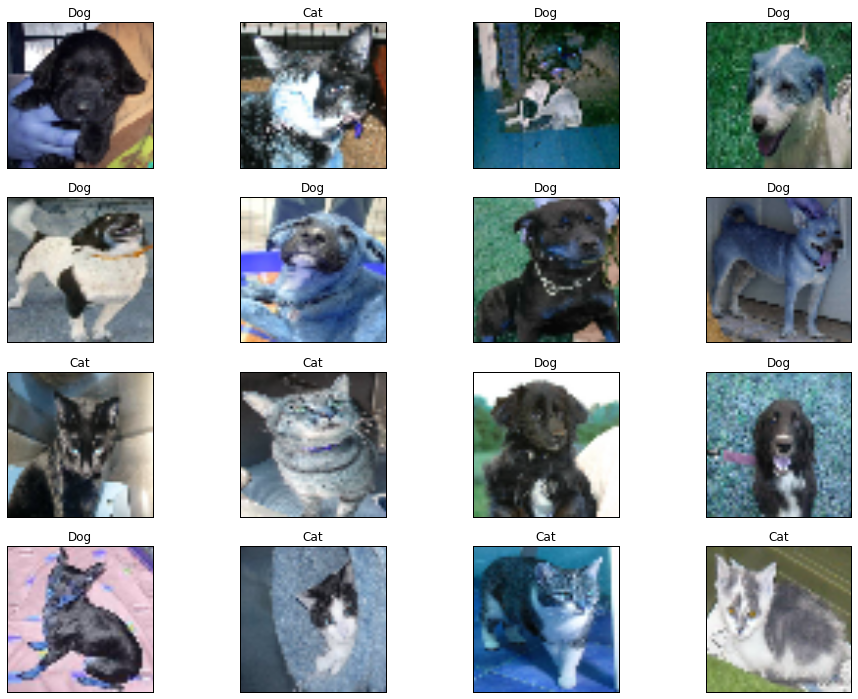

In [3]:
%matplotlib inline
from __future__ import division, print_function, absolute_import
from random import shuffle
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tqdm import tqdm
from tflearn.metrics import Accuracy
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

# Defining some required parameters
# Use sample_train for training and sample_valid for testing to get lower execution time

train_dir = 'DataSet/train'
validation_dir = 'DataSet/sample_valid'
test_dir = 'DataSet/sample_train'

image_size = 50
lr = 0.0005
Model_Name = 'cats-vs-dogs-conv'


def create_label(image_name):
    """Creating one-hot-encoded vector from images"""
    img_name = image_name.split('.')[-3]
    if img_name == 'cat':
        return np.array([1, 0]) # 1 represents it's a cat
    elif img_name == 'dog':
        return np.array([0, 1])


def create_training_data():
    training_data = []
    for img in tqdm(os.listdir(train_dir)):
        path = os.path.join(train_dir, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (image_size, image_size))
        training_data.append([np.array(img_data), create_label(img)])
    shuffle(training_data)
    np.save('training_data_B&W.npy', training_data)
    return training_data


def create_testing_data():
    testing_data = []
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (image_size, image_size))
        testing_data.append([np.array(img_data), create_label(img)])
    shuffle(testing_data)
    np.save('testing_data_B&W.npy', testing_data)
    return testing_data


def create_validation_data():
    validation_data = []
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (image_size, image_size))
        validation_data.append([np.array(img_data), create_label(img)])
    shuffle(validation_data)
    np.save('validation_data_B&W.npy', validation_data)
    return validation_data


# Creating training and testing data if it isn't already done
# train_data = create_training_data()
# validate_data = create_validation_data()
# test_data = create_testing_data()

# If dataset has already been created you can import it using
train_data = np.load('training_data_COLOR.npy')
test_data = np.load('testing_data_COLOR.npy')
validate_data = np.load('validation_data_COLOR.npy')


# Create extra synthetic training data by flipping & rotating images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)



train = train_data[::]
test = test_data[::]
validate = validate_data[::]
X_train = np.array([i[0] for i in train]).reshape(-1, image_size, image_size, 3)
y_train = [i[1] for i in train]
X_test = np.array([i[0] for i in test]).reshape(-1, image_size, image_size, 3)
y_test = np.array([i[1] for i in test])
X_validate = np.array([i[0] for i in validate]).reshape(-1, image_size, image_size, 3)
y_validate = [i[1] for i in validate]

# Actually building the model
tf.reset_default_graph()
convnet = input_data(shape = [None, image_size, image_size, 3], data_augmentation=img_aug, name='input')
convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.6)
convnet = fully_connected(convnet, 2, activation='softmax')

acc = Accuracy(name="Accuracy")
convnet = regression(convnet, optimizer='adam', learning_rate=lr, loss='categorical_crossentropy', metric=acc)
# Just some stuff that has to be done for tensorboard
model = tflearn.DNN(convnet, tensorboard_dir='log', checkpoint_path = 'checkpoints', max_checkpoints = 5, tensorboard_verbose = 3)

# This is the code that fits the data into the model
model.fit(X_train, y_train, n_epoch = 250, batch_size = 512, validation_set = (X_validate, y_validate), 
#          show_metric=True, run_id = Model_Name, shuffle=True)

# Saving the trained model
model.save('trained_cnn.tflearn')


# Here we will check the accuracy of our trained model on data it has never seen before
model.load('trained_cnn.tflearn')
acc = model.evaluate(X_test, y_test)
print("Accuracy of model: ",acc)

fig = plt.figure(figsize=(16,12))
for num, data in enumerate(test_data[16:32]):
    img_num = data[1]
    img_data = data[0]

    y = fig.add_subplot(4, 4, num + 1)
    orig = img_data
    data = img_data.reshape(image_size, image_size, 3)
    model_out = model.predict([data])[0]

    if np.argmax(model_out) == 1:
        str_label = 'Dog'
    else:
        str_label = 'Cat'

    y.imshow(orig)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
